# What is Sentiment Analysis?

Sentiment analysis (also known as opinion mining) is one of the many applications of Natural Language Processing. It is a set of methods and techniques used for extracting subjective information from text or speech, such as opinions or attitudes. In simple terms, it involves classifying a piece of text as positive, negative or neutral.

The objective is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

We will classify a set of tweets into two categories:

1. racist/sexist
2. non-racist/sexist

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

The metric used for evaluating the performance of classification model would be F1-Score.

The metric can be understood as -

1. True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

2. True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

3. False Positives (FP) – When actual class is no and predicted class is yes.

4. False Negatives (FN) – When actual class is yes but predicted class in no.

5. Precision = TP/TP+FP

6. Recall = TP/TP+FN

7. F1 Score = 2*(Recall * Precision) / (Recall + Precision)

F1 is usually more useful than accuracy, especially if for an uneven class distribution.

### Data: https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/

In [1]:
#Importing the necessary libraries
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
train  = pd.read_csv('train_E6oV3lV.csv') 
test = pd.read_csv('test_tweets_anuFYb8.csv')

Text is a highly unstructured form of data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing. 

In [3]:
train[train['label']==0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [4]:
train[train['label']==1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.

In [5]:
print(train.shape,test.shape)

(31962, 3) (17197, 2)


In [6]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In the train dataset, we have 2,242 (7%) tweets labeled as racist or sexist, and 29,720 (93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

Now, checking the distribution of length of the tweets, in terms of words, in both train and test data.

In [7]:
ltrain= train.tweet.str.len()
ltest= test.tweet.str.len()

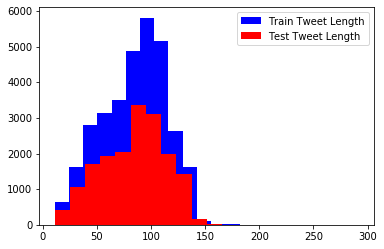

In [8]:
plt.hist(ltrain,bins=20,color='blue',label='Train Tweet Length')
plt.hist(ltest,bins=20,color='red',label='Test Tweet Length')
plt.legend(loc='best')
plt.show()

### Cleaning the data

cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.


In [9]:
train['source']='train'
test['source']= 'test'

combi= train.append(test,ignore_index=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
def cleaning(pattern,string):
    r= re.findall(pattern,string)
    for i in r:
        string= re.sub(i,'',string)
    return string

We will be following the steps below to clean the raw tweets in out data.

1. We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

2. We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

3. Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

4. Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

In [11]:
combi.head()

,id,label,source,tweet
0,1,0.0,train,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,train,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,train,bihday your majesty
3,4,0.0,train,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,train,factsguide: society now #motivation


In [12]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lem= WordNetLemmatizer()
combi['tidy_tweet']='' # Setting new column with blank value to get tidy tweets
for i in range(len(combi['tweet'])):
    r= re.sub("@[\w]*",' ',combi['tweet'][i])# will replace any word starting with ‘@’.
    r= re.sub("[^a-zA-Z#]", ' ', r) # Here we will replace everything except characters and hashtags with spaces. 
    r= r.lower() # changing everythig to lower case
    r= word_tokenize(r) # tokenization to get words
    r= [lem.lemmatize(x) for x in r if x not in set(stopwords.words())] # lemmatizing all the actual words and removing unwanted words
    combi['tidy_tweet'][i]= ' '.join(r) # creating back the sentence in new column
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [13]:
# tweets= combi[combi['tidy_tweet']!='']

# train1= tweets[tweets['source']=='train']

# test1= tweets[tweets['source']=='test']

# train1.drop(['id','source','tweet'],axis=1,inplace=True)

# test1.drop(['id','source','tweet'],axis=1,inplace=True)

In [14]:
combi.head(10)

,id,label,source,tweet,tidy_tweet
0,1,0.0,train,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction # run
1,2,0.0,train,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks # lyft credit use cause offer wheelchair van pdx # disapointed # getthanked
2,3,0.0,train,bihday your majesty,bihday majesty
3,4,0.0,train,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,# model love take time ur
4,5,0.0,train,factsguide: society now #motivation,factsguide society # motivation
5,6,0.0,train,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare big talking leave chaos pay dispute get # allshowandnogo
6,7,0.0,train,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,train,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exam think # school # exam # hate # imagine # actorslife # revolutionschool # girl
8,9,0.0,train,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land # allin # cavs # champion # cleveland # clevelandcavaliers
9,10,0.0,train,@user @user welcome here ! i'm it's so #gr8 !,welcome # gr


In [15]:
combi.tail()

,id,label,source,tweet,tidy_tweet
49154,49155,NaN,test,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,thought factory left right polarisation # trump # uselections # leadership # politics # brexit # blm gt
49155,49156,NaN,test,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,feeling like mermaid # hairflip # neverready # formal # wedding # gown # dress # mermaid
49156,49157,NaN,test,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",# hillary # campaigned today # ohio omg amp used word like asset amp liability never # clinton say thee word # radicalization
49157,49158,NaN,test,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",happy work conference right mindset lead culture development organization # work # mindset
49158,49159,NaN,test,"my song ""so glad"" free download! #shoegaze #newmusic #newsong",song glad free download # shoegaze # newmusic # newsong


# WordCloud
understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

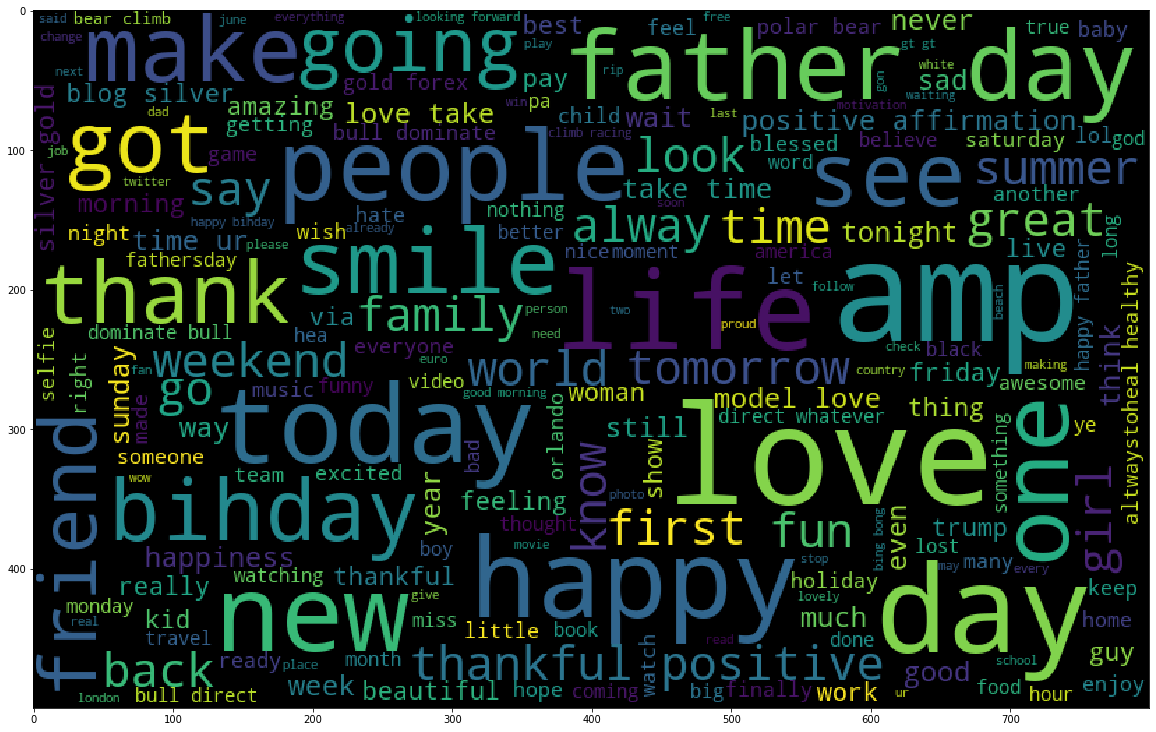

In [22]:
all_words= ' '.join( [text for text in combi['tidy_tweet']])

from wordcloud import WordCloud

cloud= WordCloud(width=800,height=500,random_state=10,max_font_size=100).generate(all_words)

plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

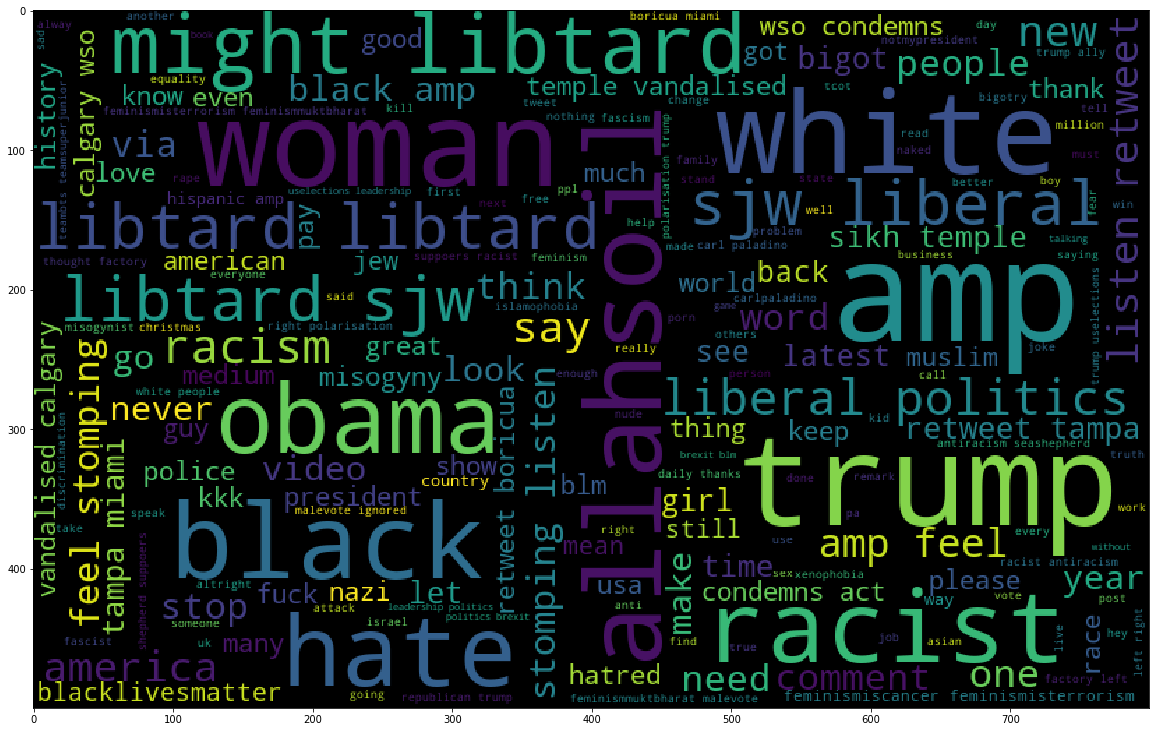

In [25]:
racist_words= ' '.join( [text for text in combi[combi['label']==1]['tidy_tweet']])
cloud= WordCloud(width=800,height=500,random_state=10,max_font_size=100).generate(racist_words)

plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

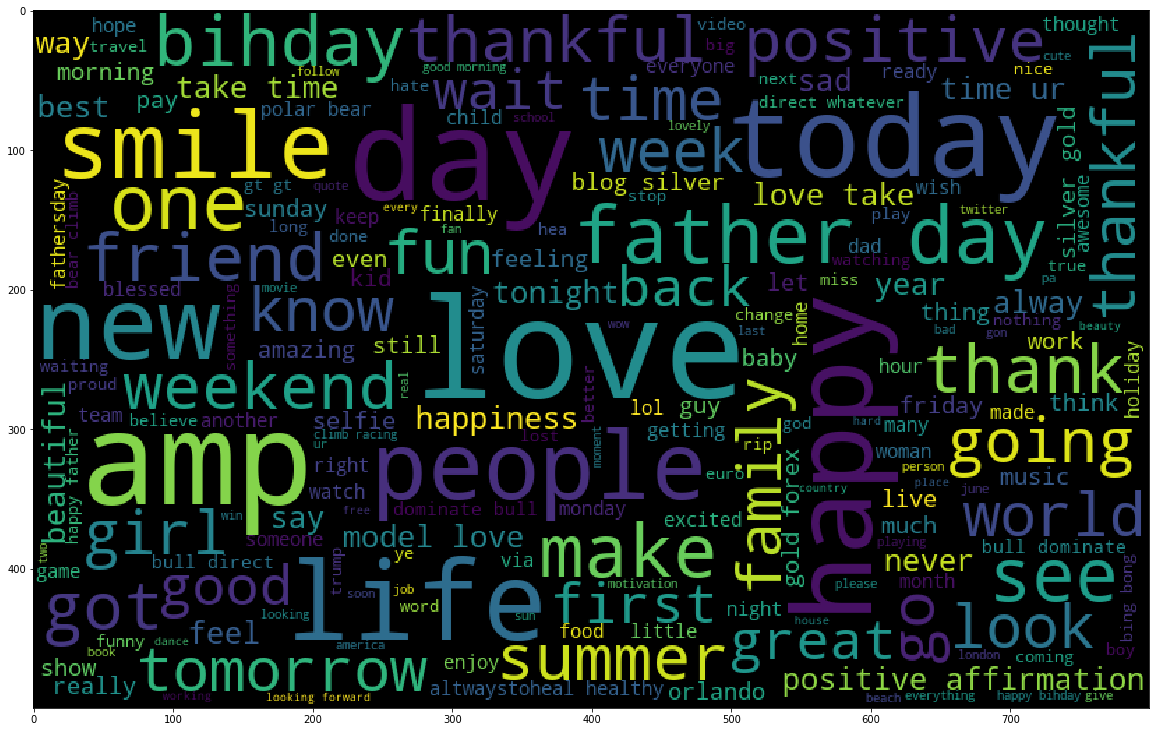

In [26]:
nonracist_words= ' '.join( [text for text in combi[combi['label']==0]['tidy_tweet']])
cloud= WordCloud(width=800,height=500,random_state=10,max_font_size=100).generate(nonracist_words)

plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.show()

# Understanding the impact of Hashtags on tweets sentiment

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:



The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.1

In [27]:
re.findall('#\s(\w+)','feeling like mermaid # hairflip # neverready # formal # wedding # gown # dress # mermaid')

['hairflip', 'neverready', 'formal', 'wedding', 'gown', 'dress', 'mermaid']

In [34]:
# Extracting Non Racist Hastags
hashtag=[]
for text in combi[combi['label']==0]['tidy_tweet']:
    ht= re.findall('#\s(\w+)',text)
    hashtag.append(ht)

ht_non_racist=sum(hashtag,[])

    

In [35]:
# Extracting Racist Hastags
hashtag=[]
for text in combi[combi['label']==1]['tidy_tweet']:
    ht= re.findall('#\s(\w+)',text)
    hashtag.append(ht)

ht_racist=sum(hashtag,[])

In [36]:
nltk.FreqDist(ht_non_racist) 

FreqDist({'love': 1608, 'positive': 881, 'smile': 644, 'healthy': 576, 'thankful': 496, 'fun': 464, 'life': 438, 'affirmation': 423, 'summer': 396, 'cute': 367, ...})

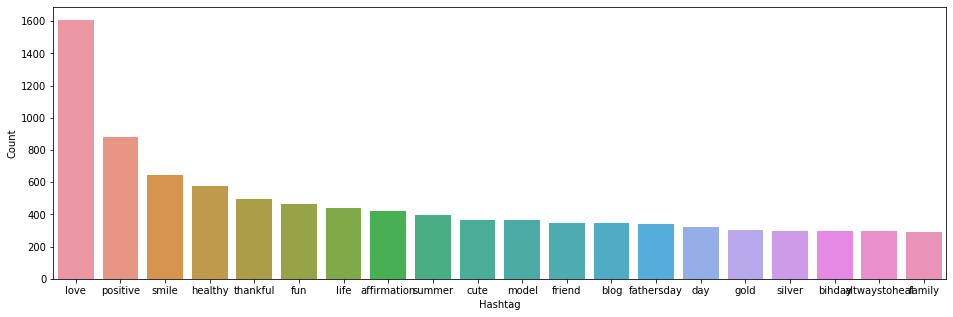

In [37]:
#Plotting top 20 Non_racist hastags
a = nltk.FreqDist(ht_non_racist) 
d = pd.DataFrame({'Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list.

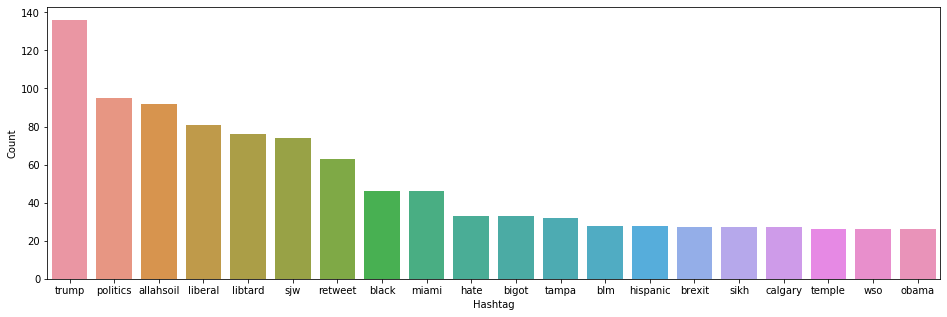

In [38]:
#Plotting top 20 racist hastags
a = nltk.FreqDist(ht_racist) 
d = pd.DataFrame({'Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. 

# Text Analysing

1. Bag of words
2. Tf-IDF
3. Word2vec

In [55]:
# Extracting train and test again from combi
tidy_train= combi[combi['source']=='train']

tidy_test= combi[combi['source']=='test']

tidy_train.drop(['id','source','tweet'],axis=1,inplace=True)

tidy_test.drop(['id','source','tweet','label'],axis=1,inplace=True)

tidy_test.reset_index(drop=True,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [74]:
bow= CountVectorizer(max_features=2500)
bow_x= bow.fit_transform(tidy_train['tidy_tweet']).toarray()
bow_y= tidy_train['label']

TF = (Number of times term t appears in a document)/(Number of terms in the document)

IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

TF-IDF = TF*IDF

In [137]:
tfidf= TfidfVectorizer(max_features=2500)
tfidf_x= tfidf.fit_transform(tidy_train['tidy_tweet']).toarray()
tfidf_y= tidy_train['label']

# Word2Vec

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are able to achieve tasks like King -man +woman = Queen, which is mind-blowing.

The advantages of using word embeddings over BOW or TF-IDF are:

1. Dimensionality reduction - significant reduction in the no. of features required to build a model.

2. It capture meanings of the words, semantic relationships and the different types of contexts they are used in.

### Word2Vec Embeddings

Word2Vec is not a single algorithm but a combination of two techniques – CBOW (Continuous bag of words) and Skip-gram model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.


CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

This is the representation of a 1-word context window Word2Vec model.

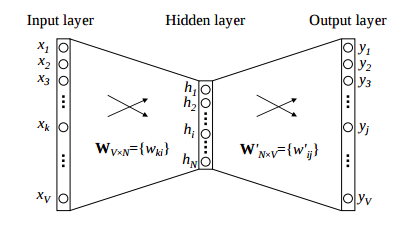



There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using pre-trained word vectors instead of training our own model. Some of the freely available pre-trained vectors are:

1. Google News Word Vectors

2. Freebase names

3. DBPedia vectors (wiki2vec)

we will train our own word vectors since size of the pre-trained word vectors is generally huge.

In [79]:
import gensim
from gensim.models import Word2Vec

In [110]:
tokenized_tweet= combi['tidy_tweet'].apply(lambda x: word_tokenize(x))

In [111]:
model_w2v = Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6788485, 9758380)

In [112]:
# the vector representation of any word from our corpus.
model_w2v['trump'].shape

(200,)

Below we can see that our word2vec model does a good job of finding the most similar words for a given word. But how is it able to do so? That’s because it has learned vectors for every unique word in our data and it uses cosine similarity to find out the most similar vectors (words).

In [113]:
model_w2v.wv.most_similar(positive="dinner")

[('bihdaydinner', 0.5668262243270874),
 ('bolognese', 0.5655569434165955),
 ('foodblogger', 0.5588945746421814),
 ('foodcoma', 0.5542425513267517),
 ('pasta', 0.5505975484848022),
 ('spaghetti', 0.5501922369003296),
 ('cookout', 0.5464496612548828),
 ('lamb', 0.5455117225646973),
 ('shawarma', 0.5430961847305298),
 ('canberra', 0.538323163986206)]

In [114]:
model_w2v.wv.most_similar(positive="love")

[('japa', 0.5667004585266113),
 ('blancapi', 0.5545535087585449),
 ('ciao', 0.5520082712173462),
 ('mexicocity', 0.5513408780097961),
 ('valentinesday', 0.5457973480224609),
 ('kiddos', 0.5449358224868774),
 ('uv', 0.542709231376648),
 ('compass', 0.5381065011024475),
 ('motheranddaughter', 0.5358550548553467),
 ('cassidy', 0.5341266989707947)]

In [115]:
model_w2v.wv.most_similar(positive="food")

[('foodblogger', 0.569119930267334),
 ('foodporn', 0.5314686894416809),
 ('integral', 0.524206280708313),
 ('delicious', 0.5141106843948364),
 ('instafood', 0.5140990018844604),
 ('foodie', 0.5114187598228455),
 ('hotdog', 0.5050498247146606),
 ('seafood', 0.504488468170166),
 ('meal', 0.4992629885673523),
 ('fotd', 0.49445220828056335)]

# Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.



In [116]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary   
            continue
    if count != 0:
        vec /= count
    return vec

In [117]:
# Preparing word2vec feature set

wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays) 
    
wordvec_df.shape  

(49159, 200)

In [118]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.285626,0.000420,-0.448879,0.021108,0.289547,0.267605,-0.164237,0.065861,-0.221965,-0.210716,...,-0.029859,0.143522,0.563981,0.314195,0.095441,0.197125,-0.165175,0.093434,0.094925,-0.210559
1,0.198133,0.048848,-0.269346,-0.002545,0.336397,0.237527,-0.266911,0.179831,0.146942,-0.114965,...,0.070004,-0.116324,0.222274,0.097858,-0.100210,0.029991,-0.276518,-0.000136,-0.049444,-0.299386
2,0.036903,0.367024,-0.444489,0.225984,0.170217,0.318249,-0.009989,-0.155962,-0.107062,0.413346,...,-0.516496,0.177781,0.277260,0.408048,0.222848,-0.087812,0.230668,-0.157904,-0.024825,-0.223178
3,0.340258,0.310442,-0.278947,0.064423,0.313213,0.277957,-0.361591,0.160461,0.033283,-0.352975,...,-0.005966,-0.226453,0.191176,0.242742,0.246050,0.107950,-0.285897,-0.178529,0.301753,-0.328281
4,0.303968,0.043015,-0.464203,-0.097706,0.187474,0.186388,-0.121023,0.233343,0.007290,-0.487985,...,0.048854,-0.191788,0.409275,0.352089,0.231886,-0.093423,-0.116152,-0.097097,-0.068485,-0.166320


In [120]:
train_word2vec= wordvec_df.iloc[:31962,:]
test_word2vec= wordvec_df.iloc[31962:,:]

word2vec_x= train_word2vec
word2vec_y= tidy_train['label']

In [121]:
word2vec_x.shape

(31962, 200)

In [122]:
word2vec_y.shape

(31962,)

# Multinomial Naive Bayes

### Bow

In [123]:
from sklearn.model_selection import train_test_split as tts
xtrain,xtest,ytrain,ytest = tts(bow_x,bow_y,test_size=0.3)

In [127]:
from sklearn.naive_bayes import MultinomialNB
model= MultinomialNB()
model.fit(xtrain,ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [128]:
model.score(xtest,ytest)

0.9445197622275524

In [129]:
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,accuracy_score
print('Roc_AUC: {}, Precision: {}, Recall:{}, F1:{}, Accuracy:{}'.format(
roc_auc_score(ytest,model.predict(xtest)),
precision_score(ytest,model.predict(xtest)),
recall_score(ytest,model.predict(xtest)),
f1_score(ytest,model.predict(xtest)),
accuracy_score(ytest,model.predict(xtest))))

Roc_AUC: 0.8051658499062359, Precision: 0.5760111576011158, Recall:0.6443057722308893, F1:0.6082474226804123, Accuracy:0.9445197622275524


In [131]:
test_pred = model.predict(CountVectorizer(max_features=2500).fit(tidy_train['tidy_tweet']).transform(tidy_test['tidy_tweet']).toarray())

In [132]:
test_pred

array([0., 0., 0., ..., 1., 0., 0.])

### Tf-IDF

In [178]:
from sklearn.ensemble import RandomForestClassifier
xtrain,xtest,ytrain,ytest = tts(tfidf_x,tfidf_y,test_size=0.3)
model= MultinomialNB()
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.948795494837835

In [179]:
print('Roc_AUC: {}, Precision: {}, Recall:{}, F1:{}, Accuracy:{}'.format(
roc_auc_score(ytest,model.predict(xtest)),
precision_score(ytest,model.predict(xtest)),
recall_score(ytest,model.predict(xtest)),
f1_score(ytest,model.predict(xtest)),
accuracy_score(ytest,model.predict(xtest))))

Roc_AUC: 0.6663946611381643, Precision: 0.9003831417624522, Recall:0.3357142857142857, F1:0.48907388137356916, Accuracy:0.948795494837835


In [180]:
from sklearn.model_selection import cross_val_score, cross_val_predict
cv= cross_val_score(model,xtest,ytest,cv=5, scoring='f1')

In [181]:
np.mean(cv)

0.36010974502576354

In [182]:
test_pred = model.predict(TfidfVectorizer(max_features=2500).fit(tidy_train['tidy_tweet']).transform(tidy_test['tidy_tweet']).toarray())

In [183]:
test_pred

array([0., 0., 0., ..., 0., 0., 0.])

### Word2vec

In [184]:
xtrain,xtest,ytrain,ytest = tts(word2vec_x,word2vec_y,test_size=0.3)
from sklearn.linear_model import LogisticRegression
model= LogisticRegression()
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9491083533215142

In [185]:
print('Roc_AUC: {}, Precision: {}, Recall:{}, F1:{}, Accuracy:{}'.format(
roc_auc_score(ytest,model.predict(xtest)),
precision_score(ytest,model.predict(xtest)),
recall_score(ytest,model.predict(xtest)),
f1_score(ytest,model.predict(xtest)),
accuracy_score(ytest,model.predict(xtest))))

Roc_AUC: 0.7374166002353251, Precision: 0.6953781512605042, Recall:0.4910979228486647, F1:0.5756521739130435, Accuracy:0.9491083533215142


In [188]:
test_pred = model.predict(test_word2vec)

In [189]:
test_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [190]:
from xgboost import XGBClassifier

In [191]:
model= XGBClassifier(max_depth=5, n_estimators=400, n_jobs=-1,random_state=20,learning_rate=0.15)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.9628741266033998

In [192]:
print('Roc_AUC: {}, Precision: {}, Recall:{}, F1:{}, Accuracy:{}'.format(
roc_auc_score(ytest,model.predict(xtest)),
precision_score(ytest,model.predict(xtest)),
recall_score(ytest,model.predict(xtest)),
f1_score(ytest,model.predict(xtest)),
accuracy_score(ytest,model.predict(xtest))))

Roc_AUC: 0.7866508784747476, Precision: 0.8412017167381974, Recall:0.5816023738872403, F1:0.6877192982456141, Accuracy:0.9628741266033998


In [193]:
test_pred = model.predict(test_word2vec)

## Parameter Tuning

XGBoost with Word2Vec model has given us the best performance so far. Let’s try to tune it further to extract as much from it as we can. 

Using GridSearchCV i got below best prameters.

{'colsample': 0.9,
     'colsample_bytree': 0.5, 'learning_rate': 0.1,
 'max_depth': 8, 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.9}

In [194]:
model= XGBClassifier(max_depth=8,objective= 'binary:logistic',
                     n_estimators=1000, n_jobs=-1,
                     random_state=20,learning_rate=0.1,
                    min_child_weight=6,colsample_bytree=0.5,
                    subsample=0.5)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.9630826989258525

In [195]:
print('Roc_AUC: {}, Precision: {}, Recall:{}, F1:{}, Accuracy:{}'.format(
roc_auc_score(ytest,model.predict(xtest)),
precision_score(ytest,model.predict(xtest)),
recall_score(ytest,model.predict(xtest)),
f1_score(ytest,model.predict(xtest)),
accuracy_score(ytest,model.predict(xtest))))

Roc_AUC: 0.7915633305651296, Precision: 0.8347280334728033, Recall:0.5919881305637982, F1:0.6927083333333333, Accuracy:0.9630826989258525


In [197]:
pred= model.predict(test_word2vec)

In [198]:
pred

array([0., 0., 0., ..., 1., 0., 0.])

Getting solution file for the hackthon

In [211]:
data= pd.DataFrame(data=pred,index=range(31963,49160))

In [212]:
data.reset_index(inplace=True)

In [213]:
data.columns= ['id','label']

In [214]:
data.to_csv('final.csv',index=False)

# Using Neural Networks

In [216]:
# Libraries for ANN
import keras
from keras.models import Sequential # Used to initialise our ANN
from keras.layers import Dense # Use to built layers of ANN
from keras.layers import LeakyReLU,PReLU,ELU # Activation functions
from keras.layers import Dropout # For Dropout Regualarisation

Using TensorFlow backend.


In [218]:
model= Sequential()

# First Input layer and hidden layer creation
model.add(Dense(units=100, 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     input_dim= xtrain.shape[1]
                    ))
model.add(Dropout(0.2))

#Second Hidden Lyer
model.add(Dense(units=100, 
                     activation='relu',
                     kernel_initializer='he_uniform',
                    ))
model.add(Dropout(0.2))

#Third Hiden Layer
model.add(Dense(units=100, 
                     activation='relu',
                     kernel_initializer='he_uniform',
                    ))
model.add(Dropout(0.2))

#Adding the output layer.
model.add(Dense(units=1, # as out put will have one layer
                     activation='sigmoid', # for binary output as o and 1, for ordinal it will be softmax
                     kernel_initializer='glorot_uniform' #Weight initialization for output from 2nd HL.
                    ))


W0820 19:06:19.126306 4716852672 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 19:06:19.148864 4716852672 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 19:06:19.152206 4716852672 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 19:06:19.176383 4716852672 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0820 19:06:19.187007 4716852672 deprecati

In [221]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [223]:
model.fit(xtrain,ytrain,batch_size=50,epochs=100)

Epoch 1/100
22373/22373 [==============================] - 1s 57us/step - loss: 0.0297 - acc: 0.9890
Epoch 2/100
22373/22373 [==============================] - 1s 55us/step - loss: 0.0246 - acc: 0.9911
Epoch 3/100
22373/22373 [==============================] - 1s 55us/step - loss: 0.0223 - acc: 0.9920
Epoch 4/100
22373/22373 [==============================] - 1s 56us/step - loss: 0.0228 - acc: 0.9917
Epoch 5/100
22373/22373 [==============================] - 1s 55us/step - loss: 0.0162 - acc: 0.9946
Epoch 6/100
22373/22373 [==============================] - 1s 59us/step - loss: 0.0214 - acc: 0.9925
Epoch 7/100
22373/22373 [==============================] - 1s 57us/step - loss: 0.0230 - acc: 0.9925
Epoch 8/100
22373/22373 [==============================] - 2s 73us/step - loss: 0.0195 - acc: 0.9929: 0s - loss: 0.0172 - acc: 
Epoch 9/100
22373/22373 [==============================] - 2s 69us/step - loss: 0.0207 - acc: 0.9928
Epoch 10/100
22373/22373 [==============================] - 1s 6

Epoch 81/100
22373/22373 [==============================] - 1s 48us/step - loss: 0.0073 - acc: 0.9974
Epoch 82/100
22373/22373 [==============================] - 1s 48us/step - loss: 0.0106 - acc: 0.9966
Epoch 83/100
22373/22373 [==============================] - 1s 49us/step - loss: 0.0093 - acc: 0.9971
Epoch 84/100
22373/22373 [==============================] - 1s 54us/step - loss: 0.0086 - acc: 0.9971: 0s - loss: 0.0086 - acc: 0.997
Epoch 85/100
22373/22373 [==============================] - 1s 53us/step - loss: 0.0083 - acc: 0.9970
Epoch 86/100
22373/22373 [==============================] - 1s 49us/step - loss: 0.0075 - acc: 0.9976
Epoch 87/100
22373/22373 [==============================] - 1s 53us/step - loss: 0.0114 - acc: 0.9968
Epoch 88/100
22373/22373 [==============================] - 1s 55us/step - loss: 0.0081 - acc: 0.9974
Epoch 89/100
22373/22373 [==============================] - 1s 61us/step - loss: 0.0112 - acc: 0.9962
Epoch 90/100
22373/22373 [========================

In [225]:
print('Roc_AUC: {}, Precision: {}, Recall:{}, F1:{}, Accuracy:{}'.format(
roc_auc_score(ytest,model.predict_classes(xtest)),
precision_score(ytest,model.predict_classes(xtest)),
recall_score(ytest,model.predict_classes(xtest)),
f1_score(ytest,model.predict_classes(xtest)),
accuracy_score(ytest,model.predict_classes(xtest))))

Roc_AUC: 0.8163065782838579, Precision: 0.7923497267759563, Recall:0.6454005934718101, F1:0.7113654946852003, Accuracy:0.9631869850870789


In [230]:
pred= model.predict_classes(test_word2vec)
data= pd.DataFrame(data=pred,index=range(31963,49160))
data.reset_index(inplace=True)
data.columns= ['id','label']
data.to_csv('nn.csv',index=False)